In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

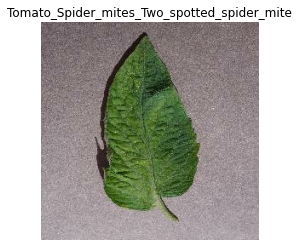

In [9]:
for images_batch, labels_batch in dataset.take(1):
    plt.title(class_names[labels_batch[0].numpy()])
    plt.imshow(images_batch[0].numpy().astype('uint8'))
    plt.axis('off')

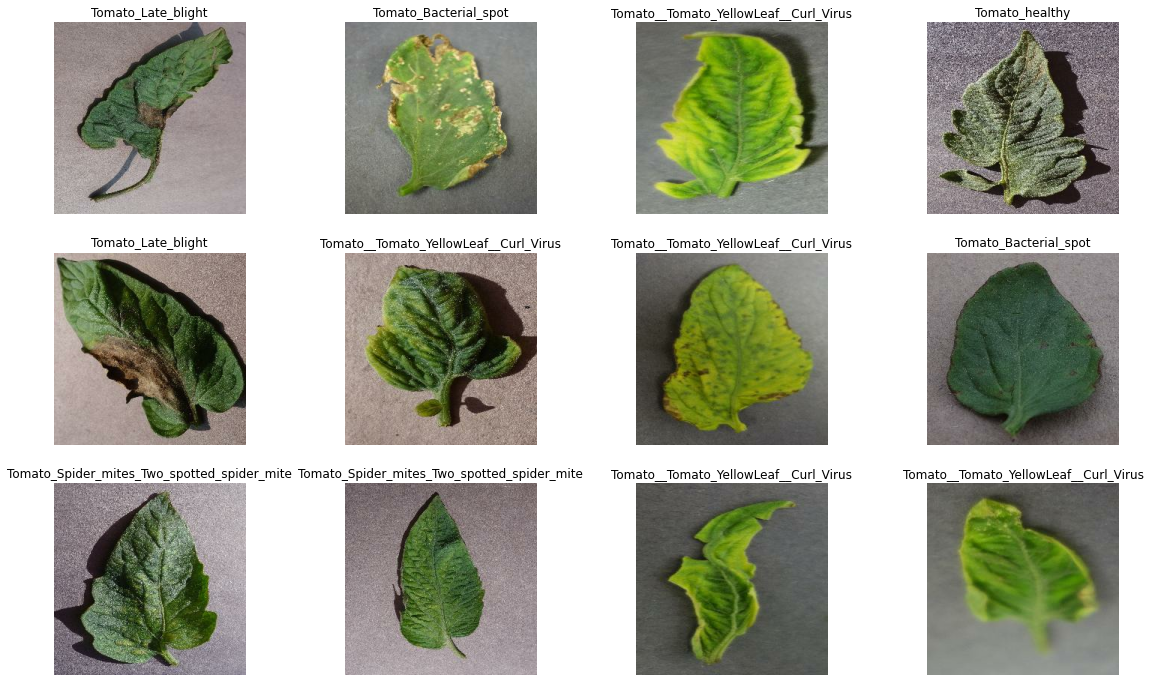

In [13]:
plt.figure(figsize=(20,12))
for images_batch, labels_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.title(class_names[labels_batch[i].numpy()])
        plt.imshow(images_batch[i].numpy().astype('uint8'))
        plt.axis('off')

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size)
    
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [26]:
len(train_ds),len(val_ds),len(test_ds)

(400, 50, 51)

In [23]:
len(dataset)

501

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [27]:
len(train_ds),len(val_ds),len(test_ds)

(400, 50, 51)

In [29]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

In [39]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
with tf.device('/GPU:1'):
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Flatten(),
        layers.Dense(64,activation='relu'),
        layers.Dense(10,activation='softmax')
    ])
    
    model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [41]:
with tf.device('/GPU:1'):
    model.compile(
        optimizer='adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

In [42]:
with tf.device('/GPU:1'):
    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        verbose=1,
        epochs=EPOCHS,
        validation_data=val_ds
        
    )

Epoch 1/50
400/400 [==============================] - 247s 607ms/step - loss: 1.5764 - accuracy: 0.4470 - val_loss: 1.1873 - val_accuracy: 0.5950
Epoch 2/50
400/400 [==============================] - 142s 355ms/step - loss: 0.9091 - accuracy: 0.6856 - val_loss: 1.2907 - val_accuracy: 0.5788
Epoch 3/50
400/400 [==============================] - 125s 313ms/step - loss: 0.6307 - accuracy: 0.7818 - val_loss: 1.2439 - val_accuracy: 0.6131
Epoch 4/50
400/400 [==============================] - 139s 347ms/step - loss: 0.5162 - accuracy: 0.8156 - val_loss: 1.0621 - val_accuracy: 0.6587
Epoch 5/50
400/400 [==============================] - 158s 396ms/step - loss: 0.4410 - accuracy: 0.8439 - val_loss: 1.2095 - val_accuracy: 0.6562
Epoch 6/50
400/400 [==============================] - 134s 334ms/step - loss: 0.3754 - accuracy: 0.8648 - val_loss: 1.0244 - val_accuracy: 0.6888
Epoch 7/50
400/400 [==============================] - 133s 333ms/step - loss: 0.3329 - accuracy: 0.8855 - val_loss: 0.7083 -

400/400 [==============================] - 92s 230ms/step - loss: 0.1002 - accuracy: 0.9653 - val_loss: 0.4546 - val_accuracy: 0.8656
Epoch 33/50
400/400 [==============================] - 92s 229ms/step - loss: 0.0947 - accuracy: 0.9667 - val_loss: 0.7083 - val_accuracy: 0.8175
Epoch 34/50
400/400 [==============================] - 90s 225ms/step - loss: 0.0745 - accuracy: 0.9736 - val_loss: 0.3313 - val_accuracy: 0.9044
Epoch 35/50
400/400 [==============================] - 90s 226ms/step - loss: 0.0978 - accuracy: 0.9655 - val_loss: 0.4618 - val_accuracy: 0.8631
Epoch 36/50
400/400 [==============================] - 90s 224ms/step - loss: 0.0875 - accuracy: 0.9736 - val_loss: 0.8063 - val_accuracy: 0.8000
Epoch 37/50
400/400 [==============================] - 92s 230ms/step - loss: 0.0834 - accuracy: 0.9696 - val_loss: 0.4020 - val_accuracy: 0.8831
Epoch 38/50
400/400 [==============================] - 92s 229ms/step - loss: 0.0836 - accuracy: 0.9703 - val_loss: 0.2197 - val_accurac

In [44]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 2s 30ms/step - loss: 0.4120 - accuracy: 0.8995


In [45]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

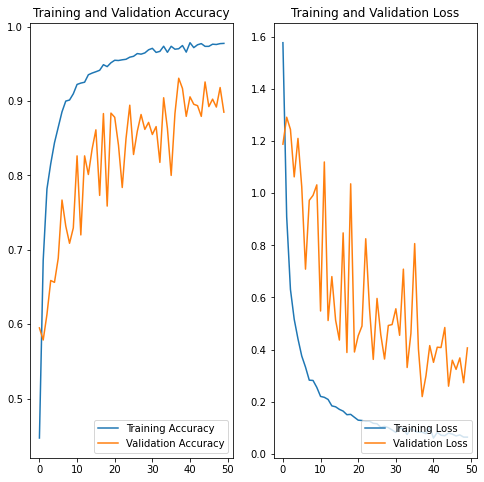

In [48]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [49]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    prediction_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return prediction_class, confidence

1/1 [==============================] - 0s 30ms/step


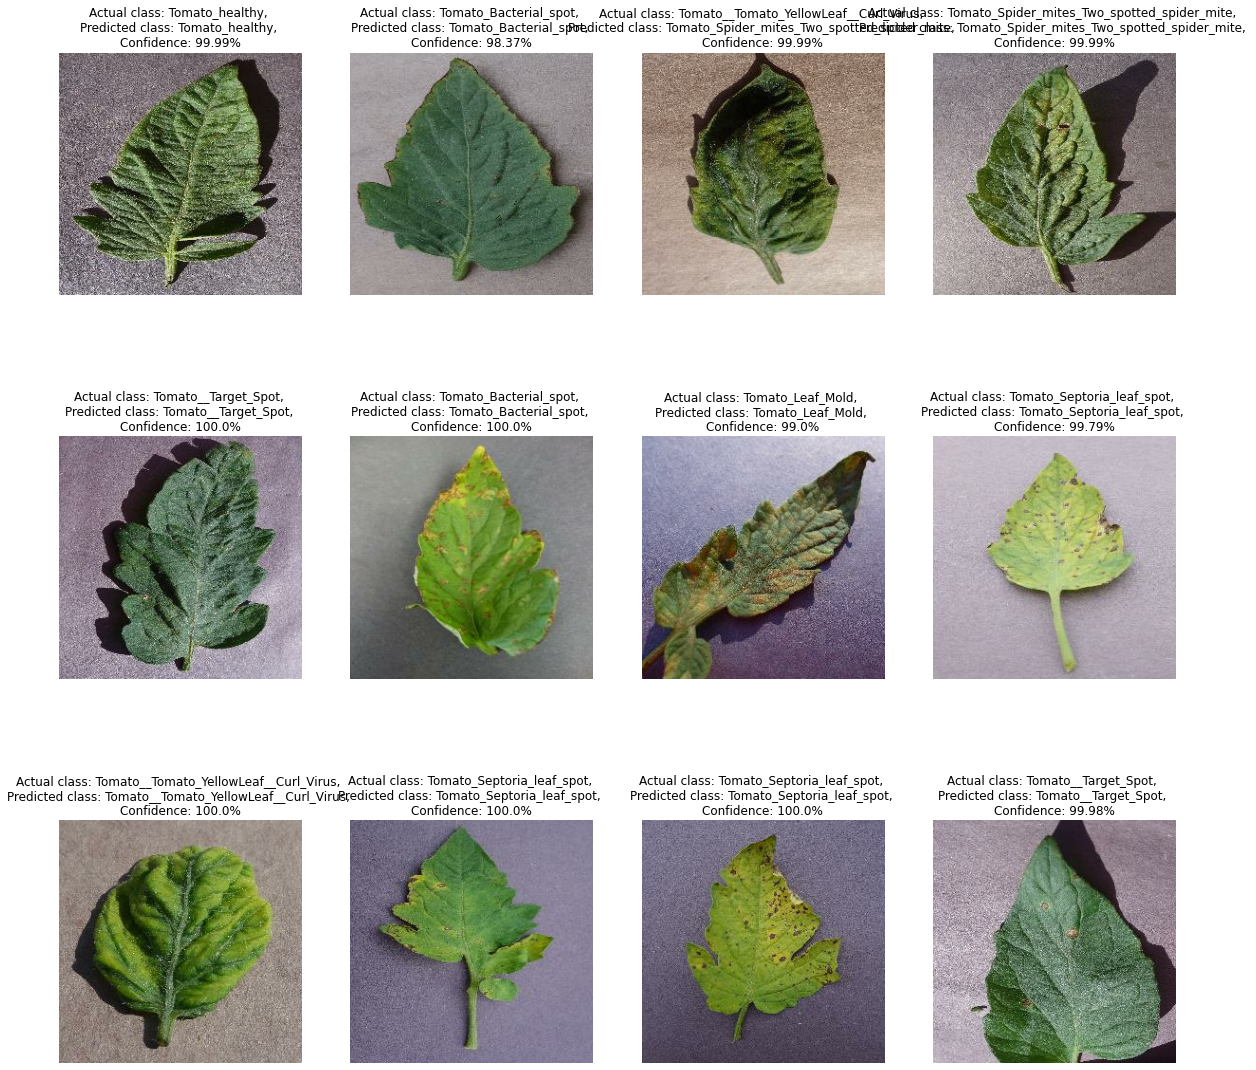

In [52]:
plt.figure(figsize=(20,20))

for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        prediction_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i].numpy()]
        plt.title(f"Actual class: {actual_class}, \nPredicted class: {prediction_class}, \nConfidence: {confidence}%")
        